In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
from skimage.io import imread
from tqdm.auto import tqdm
import json
from src.GLC.metrics import *

In [2]:
path = Path("../data")
obs_fr = pd.read_csv(path / "observations" / f"observations_fr_train.csv", sep=";")
obs_us = pd.read_csv(path / "observations" / f"observations_us_train.csv", sep=";")
obs = pd.concat([obs_fr, obs_us])

obs_fr_test = pd.read_csv(path / "observations" / f"observations_fr_test.csv", sep=";")
obs_us_test = pd.read_csv(path / "observations" / f"observations_us_test.csv", sep=";")
obs_test = pd.concat([obs_fr_test, obs_us_test])

In [3]:
obs["country"] = obs["observation_id"].apply(lambda x: int(str(x)[0]) - 1)
obs.set_index(["observation_id"], inplace=True)

obs_test["country"] = obs_test["observation_id"].apply(lambda x: int(str(x)[0]) - 1)
obs_test.set_index(["observation_id"], inplace=True)

In [4]:
obs

,latitude,longitude,species_id,subset,country
observation_id,,,,,
10561949,45.705116,1.424622,241,train,0
10131188,45.146973,6.416794,101,train,0
10799362,46.783695,-2.072855,700,train,0
10392536,48.604866,-2.825003,1456,train,0
10335049,48.815567,-0.161431,157,train,0
...,...,...,...,...,...
22068171,29.602327,-94.555860,5041,train,1
22068172,38.029580,-122.883995,8688,train,1
22068173,37.913720,-121.948814,12154,train,1


In [5]:
obs_test

,latitude,longitude,country
observation_id,,,
10782781,43.601788,6.940195,0
10364138,46.241711,0.683586,0
10692017,45.181095,1.533459,0
10222322,46.938450,5.298678,0
10241950,45.017433,0.960736,0
...,...,...,...
22067746,39.896954,-87.205580,1
22067972,32.178730,-98.421890,1
22068007,38.845028,-122.385380,1


In [6]:
# Environmental variables

df_env = pd.read_csv(path / "pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")
df_env_train = df_env.loc[obs.index.values]
df_env_test = df_env.loc[obs_test.index.values]
df_env_train


,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10561949,11.229167,8.724999,37.286324,556.81506,24.5,1.1,23.400000,8.033333,18.266666,18.266666,...,211.0,287.0,1678.0,1381.0,13.0,20.0,26.0,58.0,36.0,44.0
10131188,4.587500,9.058333,33.302696,664.60220,19.9,-7.3,27.200000,1.416667,12.800000,12.833333,...,265.0,362.0,1771.0,1219.0,28.0,18.0,49.0,61.0,38.0,45.0
10799362,12.625000,6.650000,34.635418,466.43960,23.4,4.2,19.200000,8.116667,18.366667,18.416666,...,137.0,253.0,1808.0,1351.0,21.0,24.0,31.0,72.0,34.0,42.0
10392536,11.579166,6.525000,37.500000,406.30518,21.4,4.0,17.400000,7.800000,16.566666,16.733334,...,160.0,282.0,1667.0,1277.0,18.0,22.0,24.0,63.0,37.0,40.0
10335049,10.295834,7.475000,36.286407,487.07130,22.1,1.5,20.600000,5.533333,16.383333,16.383333,...,152.0,235.0,1379.0,1321.0,19.0,25.0,26.0,65.0,56.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22068171,20.345833,8.958333,34.455128,641.55160,32.4,6.4,26.000002,27.500000,16.450000,27.866667,...,361.0,280.0,2235.0,1593.0,50.0,37.0,83.0,61.0,32.0,31.0
22068172,13.458333,11.566667,63.553116,249.07861,23.3,5.1,18.199999,10.316667,15.883333,16.383333,...,21.0,551.0,2189.0,1281.0,18.0,22.0,57.0,57.0,22.0,56.0
22068173,15.162500,13.191667,49.222637,519.41895,30.5,3.7,26.800000,8.933333,21.150000,21.633333,...,12.0,324.0,322.0,1366.0,29.0,24.0,52.0,63.0,38.0,38.0


In [7]:
df_env_test

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10782781,14.837500,8.175000,34.639830,562.34546,27.5,3.9,23.600000,11.983334,21.983334,22.033333,...,127.0,256.0,1591.0,1375.0,15.0,23.0,20.0,69.0,34.0,43.0
10364138,11.854167,9.075000,38.453392,551.89530,25.4,1.8,23.600000,6.100000,18.833334,18.833334,...,151.0,213.0,1326.0,1381.0,18.0,20.0,23.0,63.0,37.0,43.0
10692017,12.512500,9.741667,38.657410,572.18134,26.8,1.6,25.199999,12.883333,19.750000,19.750000,...,191.0,225.0,1260.0,1379.0,13.0,26.0,19.0,60.0,40.0,34.0
10222322,11.170834,8.641666,33.756510,650.43854,25.5,-0.1,25.600000,11.333333,7.233334,19.216667,...,220.0,219.0,2178.0,1424.0,16.0,23.0,17.0,67.0,41.0,36.0
10241950,12.250000,9.183333,38.748240,545.07300,25.7,2.0,23.700000,9.166667,19.100000,19.100000,...,195.0,272.0,1712.0,1319.0,14.0,23.0,23.0,62.0,40.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067746,10.883333,11.516666,30.148342,981.39590,29.8,-8.4,38.199997,20.466667,-1.866667,22.516666,...,325.0,184.0,2619.0,1405.0,16.0,18.0,18.0,56.0,59.0,23.0
22067972,17.716667,13.650000,38.668556,791.49260,34.8,-0.5,35.300000,21.833332,8.716666,27.199999,...,202.0,132.0,226.0,1551.0,15.0,27.0,16.0,71.0,33.0,40.0
22068007,14.112500,15.141666,48.068783,619.32560,32.8,1.3,31.500000,7.250000,21.816666,22.050000,...,23.0,495.0,246.0,1344.0,32.0,24.0,20.0,64.0,34.0,42.0


In [8]:
# get train, val, test bioclimatic data
# X_train = df_env.loc[data_train.observation_id.values]
# X_val = df_env.loc[data_val.observation_id.values]
# X_test = df_env.loc[data_test.observation_id.values]


In [9]:
# Landcover dothot encoding

def get_patch(sample, path="../data"):
    country_id = str(sample)[0]
    country = "fr" if country_id == "1" else "us"
    subfolder = str(sample)[-2:]
    subsubfolder = str(sample)[-4:-2]
    return path + "/patches-" + country + "/" + subfolder + "/" + subsubfolder

f_dothot = lambda land, v: (land == v).sum() / 65536

def land_dothot(obs_id):
    patch = get_patch(obs_id)
    land = patch + "/" + str(obs_id) + "_landcover.tif"
    land = imread(land)
    land_dothot = np.zeros(34, dtype=np.float32)
    land_dothot[np.unique(land)] += [f_dothot(land, v) for v in np.unique(land)]
    return land_dothot
    

In [10]:
#land_dothot_list = [land_dothot(obs_id) for obs_id in tqdm(obs["observation_id"].values)]

In [11]:
#land_dothot_test_list = [land_dothot(obs_id) for obs_id in tqdm(obs_test.index)]

In [12]:
# df_dothot = pd.DataFrame(land_dothot_list) 
# df_dothot["observation_id"] = obs.index.values
# df_dothot.to_csv("land_dothot.csv", index=False)
# df_dothot
# df_dothot_test = pd.DataFrame(land_dothot_test_list) 
# df_dothot_test["observation_id"] = obs_test.index.values
# df_dothot_test.to_csv("land_dothot_test.csv", index=False)
# df_dothot_test

In [13]:
df_dothot = pd.read_csv("land_dothot.csv", index_col="observation_id")
df_dothot_test = pd.read_csv("land_dothot_test.csv", index_col="observation_id")
df_dothot_test

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
observation_id,,,,,,,,,,,,,,,,,,,,,
10782781,0.0,0.000000,0.000000,0.086670,0.557068,0.033936,0.174561,0.000000,0.147766,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
10364138,0.0,0.008850,0.016235,0.248474,0.025940,0.003967,0.003052,0.004272,0.049744,0.068970,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
10692017,0.0,0.021362,0.009155,0.112915,0.018921,0.131348,0.000000,0.000000,0.368103,0.037537,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
10222322,0.0,0.145630,0.483765,0.005493,0.001221,0.000000,0.000000,0.001526,0.011902,0.121765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
10241950,0.0,0.025635,0.004578,0.414001,0.187378,0.033875,0.000000,0.000000,0.001526,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067746,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.874176,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000
22067972,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040512,0.085342,0.000000,0.459854,0.140472,0.0,0.0,0.000000,0.00000
22068007,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012527,0.000000,0.000000,0.000000,0.783142,0.000000,0.0,0.0,0.000000,0.00000


In [14]:
# Altitude data

def alt_extraction(obs_id):
    patch = get_patch(obs_id)
    alt = patch + "/" + str(obs_id) + "_altitude.tif"
    alt = imread(alt)
    dif_alt, mean_alt = (alt.max() - alt.min()) / 5000., alt.mean() / 5000.       # min-max normalization max altitude in France is about 4000m and in USA i about 6000m
    return np.array([mean_alt, dif_alt], dtype=np.float32)

In [15]:
#alt_list = [alt_extraction(obs_id) for obs_id in tqdm(obs["observation_id"].values)]
#alt_list_test = [alt_extraction(obs_id) for obs_id in tqdm(obs_test.index)]

In [16]:
# df_alt = pd.DataFrame(alt_list) 
# df_alt["observation_id"] = obs.index.values
# df_alt.to_csv("alt.csv", index=False)
# df_alt
# df_alt_test = pd.DataFrame(alt_list_test) 
# df_alt_test["observation_id"] = obs_test.index.values
# df_alt_test.to_csv("alt_test.csv", index=False)
# df_alt_test

In [17]:
df_alt = pd.read_csv("alt.csv", index_col="observation_id")
df_alt_test = pd.read_csv("alt_test.csv", index_col="observation_id")
df_alt_test

,0,1
observation_id,,
10782781,0.024804,0.0094
10364138,0.020984,0.0082
10692017,0.043953,0.0050
10222322,0.035983,0.0016
10241950,0.049048,0.0078
...,...,...
22067746,0.043789,0.0034
22067972,0.085817,0.0028
22068007,0.127702,0.0144


In [18]:
def rgbnir_percentiles(obs_id):
    patch = get_patch(obs_id)
    rgb = patch + "/" + str(obs_id) + "_rgb.jpg"
    nir = patch + "/" + str(obs_id) + "_near_ir.jpg"
    rgb = np.percentile(imread(rgb), [25, 50, 75], axis=(0, 1)).reshape(-1)
    nir = np.percentile(imread(nir), [25, 50, 75])
    return np.concatenate([rgb, nir])

In [19]:
#rgbnir_p_list = [rgbnir_percentiles(obs_id) for obs_id in tqdm(obs["observation_id"].values)]
#rgbnir_p_test_list = [rgbnir_percentiles(obs_id) for obs_id in tqdm(obs_test.index)]


In [20]:
# rgbnir_p = pd.DataFrame(rgbnir_p_list) 
# rgbnir_p["observation_id"] = obs.index.values
# rgbnir_p.to_csv("rgbnir_percentiles.csv", index=False)
# rgbnir_p
# rgbnir_p_test = pd.DataFrame(rgbnir_p_test_list) 
# rgbnir_p_test["observation_id"] = obs_test.index.values
# rgbnir_p_test.to_csv("rgbnir_percentiles_test.csv", index=False)
# rgbnir_p_test

In [23]:
df_rgbnir_p = pd.read_csv("rgbnir_percentiles.csv", index_col="observation_id")
df_rgbnir_p_test = pd.read_csv("rgbnir_percentiles_test.csv", index_col="observation_id")
df_rgbnir_p_test = df_rgbnir_p_test[["1", "4", "7", "10"]]
df_rgbnir_p = df_rgbnir_p[["1", "4", "7", "10"]]
df_rgbnir_p

,1,4,7,10
observation_id,,,,
10561949,87.0,98.0,109.0,144.0
10131188,85.0,114.0,128.0,150.0
10799362,140.0,182.0,202.0,124.0
10392536,48.0,78.0,105.0,98.0
10335049,100.0,104.0,109.0,149.0
...,...,...,...,...
22068171,32.0,71.0,119.0,139.0
22068172,123.0,133.0,146.0,148.0
22068173,76.0,94.0,113.0,136.0


In [24]:
data = pd.concat([obs, df_env_train, df_dothot, df_alt, df_rgbnir_p], axis=1)
data_test = pd.concat([obs_test, df_env_test, df_dothot_test, df_alt_test, df_rgbnir_p_test], axis=1)
#data = pd.concat([obs, df_env_train, df_alt], axis=1)
#data_test = pd.concat([obs_test, df_env_test, df_alt_test], axis=1)
data_test

,latitude,longitude,country,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,...,30,31,32,33,0,1,1,4,7,10
observation_id,,,,,,,,,,,,,,,,,,,,,
10782781,43.601788,6.940195,0,14.837500,8.175000,34.639830,562.34546,27.5,3.9,23.600000,...,0.0,0.0,0.000000,0.00000,0.024804,0.0094,76.0,92.0,109.0,120.0
10364138,46.241711,0.683586,0,11.854167,9.075000,38.453392,551.89530,25.4,1.8,23.600000,...,0.0,0.0,0.000000,0.00000,0.020984,0.0082,30.0,32.0,80.0,80.0
10692017,45.181095,1.533459,0,12.512500,9.741667,38.657410,572.18134,26.8,1.6,25.199999,...,0.0,0.0,0.000000,0.00000,0.043953,0.0050,72.0,108.0,132.0,104.0
10222322,46.938450,5.298678,0,11.170834,8.641666,33.756510,650.43854,25.5,-0.1,25.600000,...,0.0,0.0,0.000000,0.00000,0.035983,0.0016,63.0,97.0,150.0,132.0
10241950,45.017433,0.960736,0,12.250000,9.183333,38.748240,545.07300,25.7,2.0,23.700000,...,0.0,0.0,0.000000,0.00000,0.049048,0.0078,66.0,81.0,118.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067746,39.896954,-87.205580,1,10.883333,11.516666,30.148342,981.39590,29.8,-8.4,38.199997,...,0.0,0.0,0.000000,0.00000,0.043789,0.0034,57.0,68.0,80.0,153.0
22067972,32.178730,-98.421890,1,17.716667,13.650000,38.668556,791.49260,34.8,-0.5,35.300000,...,0.0,0.0,0.000000,0.00000,0.085817,0.0028,149.0,162.0,173.0,151.0
22068007,38.845028,-122.385380,1,14.112500,15.141666,48.068783,619.32560,32.8,1.3,31.500000,...,0.0,0.0,0.000000,0.00000,0.127702,0.0144,91.0,117.0,153.0,102.0


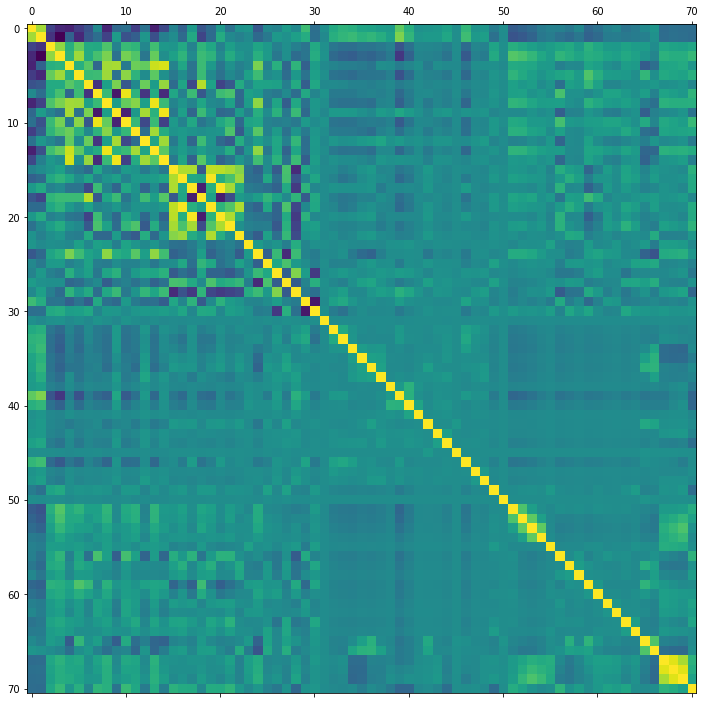

In [25]:
# Correlation matrix

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]
plt.matshow(data.corr())
plt.show()

In [26]:
#X_train = data[data["subset"] == "train"].drop(["subset", "species_id"], axis=1)
X_train = data.drop(["subset", "species_id"], axis=1)
X_val = data[data["subset"] == "val"].drop(["subset", "species_id"], axis=1)
#y_train = data[data["subset"] == "train"]["species_id"]
y_train = data["species_id"]
y_val = data[data["subset"] == "val"]["species_id"]

X_test = data_test

X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((1627475, 70), (40080, 70), (1627475,), (40080,), (36421, 70))

In [27]:
#X_train.columns = [str(x) for x in range(78)]
from sklearn.impute import SimpleImputer
imp = SimpleImputer(
    missing_values=np.nan,
    strategy="constant",
    fill_value=np.finfo(np.float32).min,
)

imp.fit(X_train)
X_train = imp.transform(X_train)
X_val = imp.transform(X_val)
X_test = imp.transform(X_test)

X_train

array([[  45.70511627,    1.42462218,    0.        , ...,   98.        ,
         109.        ,  144.        ],
       [  45.14697266,    6.4167943 ,    0.        , ...,  114.        ,
         128.        ,  150.        ],
       [  46.78369522,   -2.072855  ,    0.        , ...,  182.        ,
         202.        ,  124.        ],
       ...,
       [  37.91372   , -121.948814  ,    1.        , ...,   94.        ,
         113.        ,  136.        ],
       [  37.206974  , -122.067154  ,    1.        , ...,   82.        ,
         118.        ,  166.        ],
       [  29.806055  ,  -98.41853   ,    1.        , ...,  147.        ,
         185.        ,  151.        ]])

In [28]:
y_train_unique = y_train.unique()
for i in tqdm(range(17037)):
    if i not in y_train_unique:
        print(i)

  0%|          | 0/17037 [00:00<?, ?it/s]

In [21]:
# y_relabeling = {
#     17031: 6440,
#     17032: 6997,
#     17033: 11465,
#     17034: 12945,
#     17035: 14452,
#     17036: 16791,
# }

# y_unrelabeling = {v: k for k, v in y_relabeling.items()}

In [22]:
# for i, y in enumerate(y_train):
#     if y in y_relabeling.keys():
#         y_train.iloc[i] = y_relabeling[y]
    

In [29]:
from sklearn.ensemble import RandomForestClassifier
est = RandomForestClassifier(n_estimators=24, max_depth=13, n_jobs=-1, criterion="entropy")
est.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=13, n_estimators=24,
                       n_jobs=-1)

In [30]:
def batch_predict(predict_func, X, batch_size=800):
    res = predict_func(X[:1])
    n_samples, n_outputs, dtype = X.shape[0], res.shape[1], res.dtype
    
    preds = np.empty((n_samples, n_outputs), dtype=dtype)
    
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        preds[i:i+batch_size] = predict_func(X_batch)
            
    return preds

def predict_func(X):
    y_score = est.predict_proba(X)
    s_pred = predict_top_30_set(y_score)
    return s_pred

s_val = batch_predict(predict_func, X_val, batch_size=1024)
score_val = top_k_error_rate_from_sets(y_val, s_val)
print("Top-30 error rate: {:.1%}".format(score_val))

Top-30 error rate: 28.7%


In [31]:
def batch_predict(predict_func, X, batch_size=1024):
    res = predict_func(X[:1])
    n_samples, n_outputs, dtype = X.shape[0], res.shape[1], res.dtype
    
    preds = np.empty((n_samples, n_outputs), dtype=dtype)
    
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        preds[i:i+batch_size] = predict_func(X_batch)
            
    return preds

def predict_func(X):
    y_score = est.predict_proba(X)
    return y_score

probas_test = batch_predict(predict_func, X_test, batch_size=2048)

In [ ]:
joblib.dump(est, "./rf_final_model.joblib")
#loaded_est = joblib.load("./64rf11entropy-val_error=74.2.joblib")

['./64rf11entropy-val_error=74.2.joblib']

In [34]:
import torch
#probas_test = est.predict_proba(X_test[0:5])

In [35]:
probas_test = torch.tensor(probas_test)
#all_probas = torch.stack([probas_test, probas_test, probas_test, probas_test, probas_test])

In [29]:
preds = est.predict_proba(X_val[0:5])

In [51]:
torch.save(probas_test, "./probas_test.pt")

In [50]:
all_probas.shape

torch.Size([5, 36421, 17037])

In [52]:
y_train

observation_id
10561949      241
10131188      101
10799362      700
10392536     1456
10335049      157
            ...  
22068171     5041
22068172     8688
22068173    12154
22068174     5309
22068176     5532
Name: species_id, Length: 1627475, dtype: int64

In [53]:
_y_train = y_train.copy()

[range(0, 10)]

In [60]:
_y_train.loc[:] = list(range(1002)) + [2]*1626473

In [61]:
_y_train

observation_id
10561949    0
10131188    1
10799362    2
10392536    3
10335049    4
           ..
22068171    2
22068172    2
22068173    2
22068174    2
22068176    2
Name: species_id, Length: 1627475, dtype: int64

In [63]:
clf = XGBClassifier(n_estimators=2, max_depth=3, missing="NaN")
clf.get_params
clf.fit(X_train, _y_train)

In [134]:
# Grouping labels for multi label classification

obs["multi_labels"] = list(map(lambda x: [x], list(obs["species_id"].values)))
obs.set_index("observation_id", inplace=True)
obs

,latitude,longitude,species_id,subset,multi_labels
observation_id,,,,,
10561949,45.705116,1.424622,241,train,[241]
10131188,45.146973,6.416794,101,train,[101]
10799362,46.783695,-2.072855,700,train,[700]
10392536,48.604866,-2.825003,1456,train,[1456]
10335049,48.815567,-0.161431,157,train,[157]
...,...,...,...,...,...
22068171,29.602327,-94.555860,5041,train,[5041]
22068172,38.029580,-122.883995,8688,train,[8688]
22068173,37.913720,-121.948814,12154,train,[12154]


In [140]:
# US
cell_size = 1
for lat in tqdm(range(25, 50, cell_size)):
    for lon in tqdm(range(-125, -65, cell_size), leave=False):
        sub_group = obs[(obs["latitude"].between(lat, lat+5) & obs["longitude"].between(lon, lon+5))]
        if not sub_group.empty:
            for i, obs_i in sub_group.iterrows():
                _lat, _lon = obs_i["latitude"], obs_i["longitude"]
                neighbours = sub_group[(sub_group["latitude"].between(_lat - 0.004, _lat + 0.004) & sub_group["longitude"].between(_lon - 0.004, _lon + 0.004))]
                if not neighbours.empty:
                    dist = 0.003
                    while len(neighbours) > 30:
                        neighbours = neighbours[(neighbours["latitude"].between(_lat - dist, _lat + dist) & neighbours["longitude"].between(_lon - dist, _lon + dist))]
                        dist *= 0.75   
                    neighbours_labels = neighbours["species_id"].values
                    ml_i = obs.loc[i, "multi_labels"].copy()
                    ml_i = ml_i + list(neighbours_labels)
                    obs.at[i, "multi_labels"] = list(set(ml_i))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [141]:
# FR
for lat in tqdm(range(40, 55, cell_size)):
    for lon in tqdm(range(-5, 10, cell_size), leave=False):
        sub_group = obs[(obs["latitude"].between(lat, lat+5) & obs["longitude"].between(lon, lon+5))]
        if not sub_group.empty:
            for i, obs_i in sub_group.iterrows():
                _lat, _lon = obs_i["latitude"], obs_i["longitude"]
                neighbours = sub_group[(sub_group["latitude"].between(_lat - 0.004, _lat + 0.004) & sub_group["longitude"].between(_lon - 0.004, _lon + 0.004))]
                if not neighbours.empty:
                    dist = 0.003
                    while len(neighbours) > 30:
                        neighbours = neighbours[(neighbours["latitude"].between(_lat - dist, _lat + dist) & neighbours["longitude"].between(_lon - dist, _lon + dist))]
                        dist *= 0.75
                    neighbours_labels = neighbours["species_id"].values
                    ml_i = obs.loc[i, "multi_labels"].copy()
                    ml_i = ml_i + list(neighbours_labels)
                    obs.at[i, "multi_labels"] = list(set(ml_i))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [142]:
l_labels = list(map(lambda x: len(x), obs["multi_labels"].values))

In [143]:
np.max(l_labels), np.mean(l_labels), np.median(l_labels)

(30, 10.845431112613097, 10.0)

In [144]:
len(l_labels)

1627475

In [150]:
s = 0 
for i in range(0, 30):
    s += l_labels.count(i)
    print(i, "\t", l_labels.count(i), "\t", s)

0 	 0 	 0
1 	 170094 	 170094
2 	 128367 	 298461
3 	 102678 	 401139
4 	 86020 	 487159
5 	 75075 	 562234
6 	 66709 	 628943
7 	 61390 	 690333
8 	 56875 	 747208
9 	 54503 	 801711
10 	 54069 	 855780
11 	 53461 	 909241
12 	 53757 	 962998
13 	 54410 	 1017408
14 	 54682 	 1072090
15 	 54702 	 1126792
16 	 54449 	 1181241
17 	 54235 	 1235476
18 	 52391 	 1287867
19 	 52385 	 1340252
20 	 49633 	 1389885
21 	 46578 	 1436463
22 	 42108 	 1478571
23 	 36852 	 1515423
24 	 32762 	 1548185
25 	 26932 	 1575117
26 	 20904 	 1596021
27 	 14932 	 1610953
28 	 9785 	 1620738
29 	 5061 	 1625799


In [146]:
obs["multi_labels"].to_csv("obs_multi_labels.csv")

In [147]:
multi_labels = pd.read_csv("obs_multi_labels.csv", index_col="observation_id")

In [152]:
# Extra code to compute class weights numpy file to be used in the model

from sklearn.utils import class_weight
import numpy as np
import torch

y = obs["species_id"].values
c_w = class_weight.compute_class_weight("balanced", classes=np.unique(y), y=y)


In [155]:
c_w.min()

0.01425547145004775

In [156]:
class_weights = (c_w - 1) / 10 + 1

In [158]:
class_weights.max()

4.084197139558999

In [ ]:

np.savetxt("class_weights.csv", class_weights, delimiter=",")
data = np.loadtxt("class_weights.csv", delimiter=",")